<a href="https://colab.research.google.com/github/lucabem/CompeticionMineria/blob/main/batch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [2]:
!rm -rf /root/.keras/datasets/*

In [3]:
dataset_url = 'https://github.com/lucabem/CompeticionMineria/blob/main/data/dataset_images.zip?raw=true'
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='train_data', 
                                   extract=True)

78069760/78067648 [==============================] - 1s 0us/step


In [4]:
!rm -rf /root/.keras/datasets/train_data.tar.gz /root/.keras/datasets/train_data
!ls -l /root/.keras/datasets/

total 24
drwxr-xr-x 27 root root  4096 Mar  8 23:03 ImagesTrain
drwxr-xr-x  2 root root 20480 Mar  8 23:03 Test


In [5]:
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')
image_count = len(list(train_path.glob('*/*.jpg')))
print(image_count)

2500


In [6]:
test_path = pathlib.Path('/root/.keras/datasets/Test')
images_test = os.listdir(test_path)
print(len(images_test))

500


In [7]:
for direct in train_path.iterdir():
  if direct.is_dir():
    direct.rename(train_path / direct.name.split(sep='_100')[0])

In [8]:
batch_size = 32
img_height = 224
img_width  = 224

In [15]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 5.2MB/s 


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
import tensorflow_addons as tfa

In [17]:
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Conv2D, MaxPooling2D  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers  
from keras import backend as K  
import tensorflow as tf
keras = tf.keras

### Data Augmentation

In [18]:
batch_size  = 32
img_height = 224
img_width  = 224
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')

In [19]:
import shutil
import os 

In [20]:
train_ds_gen = ImageDataGenerator(vertical_flip    = True,
                                  horizontal_flip  = True,
                                  validation_split = 0.2)

In [21]:
train_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='training',
                                                  class_mode='categorical')

Found 2000 images belonging to 25 classes.


In [22]:
valid_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='validation',
                                                  class_mode='categorical')

Found 500 images belonging to 25 classes.


In [23]:
test_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  class_mode='categorical')

Found 2500 images belonging to 25 classes.


### Modelos

#### Funcion para predecir

In [28]:
batch_size = 68
img_height = 224
img_width  = 224
test_path  = pathlib.Path('/root/.keras/datasets/Test')

In [27]:
# predicting images
from keras.preprocessing import image
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

def make_predictions(model_final,
                     path_test ='/root/.keras/datasets/Test',
                     name_file_submission = 'submission.csv'):

  images_test = os.listdir(path_test)
  samples_to_predict = []

  for img in images_test:
    path_img = os.path.join(path_test, img)
    img = image.load_img(path_img,
                        target_size=(img_width, img_height))
    x = image.img_to_array(img)
    samples_to_predict.append(x)

  samples_to_predict  = np.array(samples_to_predict)
  predictions = model_final.predict(samples_to_predict)
  classes = np.argmax(predictions, axis = 1)

  data = {'id.jpg': images_test, 'label': classes}
  data = pd.DataFrame(data)
  data.to_csv(name_file_submission, index = False)

  return data

#### Modelo Base

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False



global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')


model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history = model.fit(  
    train_data_gen,
    epochs=39,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/39
63/63 [==============================] - 375s 6s/step - loss: 3.5592 - f1_score: 0.0479 - val_loss: 2.7924 - val_f1_score: 0.1448
Epoch 2/39
63/63 [==============================] - 370s 6s/step - loss: 2.6699 - f1_score: 0.1932 - val_loss: 2.3542 - val_f1_score: 0.3507
Epoch 3/39
63/63 [==============================] - 368s 6s/step - loss: 2.2493 - f1_score: 0.4133 - val_loss: 2.0852 - val_f1_score: 0.4473
Epoch 4/39
63/63 [==============================] - 368s 6s/step - loss: 2.0113 - f1_score: 0.5008 - val_loss: 1.8877 - val_f1_score: 0.5239
Epoch 5/39
63/63 [==============================] - 367s 6s/step - loss: 1.8279 - f1_score: 0.5581 - val_loss: 1.7658 - val_f1_score: 0.5616
Epoch 6/39
63/63 [==============================] - 367s 6s/step - loss: 1.6742 - f1_score: 0.6330 - val_loss: 1.6522 - val_f1_score: 0.6148
Epoch 7/39
63/63 [==============================] - 366s 6s/step - loss: 1.5781 - f1_score: 0.6815 - val_loss: 1.5685 - val_f1_score: 0.6581
Epoch 8/39
63

In [ ]:
model.save('model_base')

INFO:tensorflow:Assets written to: model_base/assets


In [ ]:
make_predictions(model,  name_file_submission='model_base.csv')

,id.jpg,label
0,Cereal_Cro_17.jpg,12
1,Forest_DEB_6.jpg,11
2,Forest_ODN_9.jpg,14
3,Moss_and_L_16.jpg,20
4,Forest_DDB_3.jpg,1
...,...,...
495,Close_Shru_11.jpg,2
496,Marshland__18.jpg,19
497,Forest_DEB_8.jpg,11
498,Forest_DEN_9.jpg,12


In [ ]:
from google.colab import files
files.download("model_base.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Modelo Mejorado

##### Modelo 1

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512, activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

dropout          = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_1 = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_1.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_1 = model_1.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 383s 6s/step - loss: 3.1334 - f1_score: 0.1046 - val_loss: 2.5181 - val_f1_score: 0.4795
Epoch 2/50
63/63 [==============================] - 378s 6s/step - loss: 2.5349 - f1_score: 0.3676 - val_loss: 1.9645 - val_f1_score: 0.6243
Epoch 3/50
63/63 [==============================] - 390s 6s/step - loss: 2.0416 - f1_score: 0.5068 - val_loss: 1.5346 - val_f1_score: 0.7232
Epoch 4/50
63/63 [==============================] - 389s 6s/step - loss: 1.6152 - f1_score: 0.6252 - val_loss: 1.2329 - val_f1_score: 0.7495
Epoch 5/50
63/63 [==============================] - 388s 6s/step - loss: 1.3752 - f1_score: 0.6677 - val_loss: 1.0576 - val_f1_score: 0.7800
Epoch 6/50
63/63 [==============================] - 390s 6s/step - loss: 1.1837 - f1_score: 0.7032 - val_loss: 0.9077 - val_f1_score: 0.7835
Epoch 7/50
63/63 [==============================] - 386s 6s/step - loss: 1.0406 - f1_score: 0.7454 - val_loss: 0.8434 - val_f1_score: 0.7952
Epoch 8/50
63

In [ ]:
model_1.save('model_2048_512_1024')

INFO:tensorflow:Assets written to: model_2048_512_1024/assets


In [ ]:
make_predictions(model_1, name_file_submission='modelo_mejorado_2048_512_1024.csv')

,id.jpg,label
0,Cereal_Cro_17.jpg,17
1,Forest_DEB_6.jpg,11
2,Forest_ODN_9.jpg,14
3,Moss_and_L_16.jpg,20
4,Forest_DDB_3.jpg,9
...,...,...
495,Close_Shru_11.jpg,2
496,Marshland__18.jpg,19
497,Forest_DEB_8.jpg,11
498,Forest_DEN_9.jpg,12


In [ ]:

files.download("modelo_mejorado_2048_512_1024.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
! zip -r modelo_mejorado_2048_512_1024.zip model_2048_512_1024

  adding: model_2048_512_1024/ (stored 0%)
  adding: model_2048_512_1024/variables/ (stored 0%)
  adding: model_2048_512_1024/variables/variables.index (deflated 78%)
  adding: model_2048_512_1024/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: model_2048_512_1024/assets/ (stored 0%)
  adding: model_2048_512_1024/saved_model.pb (deflated 93%)


In [ ]:
files.download("modelo_mejorado_2048_512_1024.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

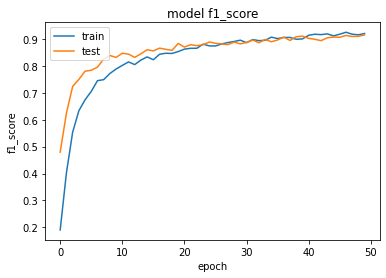

In [ ]:
plt.plot(model_history_1.history['f1_score'])
plt.plot(model_history_1.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Modelo 2

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

conv_1024 = Conv2D(1024, (3,3), activation='relu')
conv_512  = Conv2D(512, (3,3), activation='relu')

flattern  = Flatten()
batch_normal = BatchNormalization()
dropout   = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_2 = tf.keras.Sequential([
  base_model,
  conv_1024,
  conv_512,
  flattern,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])

In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_2.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'accuracy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_2 = model_2.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 534s 8s/step - loss: 2.9284 - accuracy: 0.1840 - f1_score: 0.1570 - val_loss: 1.7577 - val_accuracy: 0.5104 - val_f1_score: 0.4624
Epoch 2/50
63/63 [==============================] - 522s 8s/step - loss: 1.6498 - accuracy: 0.5271 - f1_score: 0.5170 - val_loss: 1.0158 - val_accuracy: 0.6979 - val_f1_score: 0.6819
Epoch 3/50
63/63 [==============================] - 520s 8s/step - loss: 1.0721 - accuracy: 0.6886 - f1_score: 0.6852 - val_loss: 0.7204 - val_accuracy: 0.7896 - val_f1_score: 0.7903
Epoch 4/50
63/63 [==============================] - 518s 8s/step - loss: 0.7728 - accuracy: 0.7669 - f1_score: 0.7673 - val_loss: 0.6525 - val_accuracy: 0.8021 - val_f1_score: 0.8001
Epoch 5/50
63/63 [==============================] - 517s 8s/step - loss: 0.6814 - accuracy: 0.7969 - f1_score: 0.7958 - val_loss: 0.5773 - val_accuracy: 0.8146 - val_f1_score: 0.8170
Epoch 6/50
63/63 [==============================] - 517s 8s/step - loss: 0.5503 - acc

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

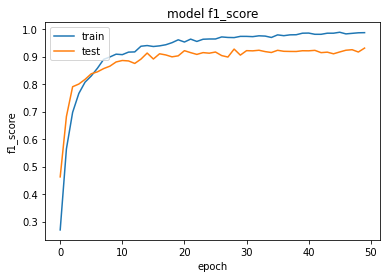

In [ ]:
plt.plot(model_history_2.history['f1_score'])
plt.plot(model_history_2.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
make_predictions(model_2, name_file_submission='modelo_mejorado_2048_512_1024_256_128_52.csv')

,id.jpg,label
0,Cereal_Cro_17.jpg,7
1,Forest_DEB_6.jpg,11
2,Forest_ODN_9.jpg,14
3,Moss_and_L_16.jpg,20
4,Forest_DDB_3.jpg,9
...,...,...
495,Close_Shru_11.jpg,2
496,Marshland__18.jpg,19
497,Forest_DEB_8.jpg,11
498,Forest_DEN_9.jpg,12


In [ ]:
files.download("modelo_mejorado_2048_512_1024_256_128_52.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_2.save('modelo_mejorado_2048_512_1024_256_128_52')

INFO:tensorflow:Assets written to: modelo_mejorado_2048_512_1024_256_128_52/assets


In [ ]:
! zip -r modelo_mejorado_2048_512_1024_256_128_52.zip modelo_mejorado_2048_512_1024_256_128_52

  adding: modelo_mejorado_2048_512_1024_256_128_52/ (stored 0%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/variables/ (stored 0%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/variables/variables.index (deflated 78%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/assets/ (stored 0%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/saved_model.pb (deflated 93%)


In [ ]:
files.download("modelo_mejorado_2048_512_1024_256_128_52.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Modelo 3

In [30]:
from keras.layers.normalization import BatchNormalization

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

model_3 = Sequential()
model_3.add(Conv2D(32,
                 kernel_size=(3, 3), 
                 activation='relu', 
                 input_shape=(224, 224, 3)))
model_3.add(BatchNormalization())

model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(BatchNormalization())

model_3.add(Conv2D(64,
                 kernel_size=(3, 3), 
                 activation='relu'))
model_3.add(BatchNormalization())

model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(BatchNormalization())

model_3.add(Flatten())

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

model_3.add(dense_layer_2048)
model_3.add(Dropout(0.25))
model_3.add(dense_layer_512)
model_3.add(Dropout(0.25))
model_3.add(dense_layer_1024)

prediction_layer = keras.layers.Dense(25, activation='softmax')

model_3.add(prediction_layer)

In [ ]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=10)

model_3.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'accuracy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_3 = model_3.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
 3/63 [>.............................] - ETA: 6:16 - loss: 3.5007 - accuracy: 0.0799 - f1_score: 0.0598

#### Predicciones

In [ ]:
make_predictions(model,  name_file_submission='model_2048_512_1024.csv')

# Modificaciones

In [31]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

conv_1024 = Conv2D(1024, (3,3), activation='relu')
conv_512  = Conv2D(512, (3,3), activation='relu')

flattern  = Flatten()
batch_normal = BatchNormalization()
dropout   = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_22 = tf.keras.Sequential([
  base_model,
  conv_1024,
  conv_512,
  flattern,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])

In [32]:
opt = tf.keras.optimizers.Adam()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_22.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'accuracy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_22 = model_22.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 507s 8s/step - loss: 3.7686 - accuracy: 0.2293 - f1_score: 0.2029 - val_loss: 1.2878 - val_accuracy: 0.6116 - val_f1_score: 0.5834
Epoch 2/50
63/63 [==============================] - 502s 8s/step - loss: 1.1953 - accuracy: 0.6121 - f1_score: 0.6069 - val_loss: 1.3384 - val_accuracy: 0.6250 - val_f1_score: 0.6093
Epoch 3/50
63/63 [==============================] - 501s 8s/step - loss: 0.8658 - accuracy: 0.7601 - f1_score: 0.7583 - val_loss: 0.8868 - val_accuracy: 0.7857 - val_f1_score: 0.7830
Epoch 4/50
63/63 [==============================] - 499s 8s/step - loss: 0.7567 - accuracy: 0.7921 - f1_score: 0.7913 - val_loss: 0.9783 - val_accuracy: 0.7857 - val_f1_score: 0.7751
Epoch 5/50
63/63 [==============================] - 503s 8s/step - loss: 0.8111 - accuracy: 0.8186 - f1_score: 0.8173 - val_loss: 0.9389 - val_accuracy: 0.7679 - val_f1_score: 0.7623
Epoch 6/50
63/63 [==============================] - 503s 8s/step - loss: 0.7786 - acc

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
plt.plot(model_history_22.history['f1_score'])
plt.plot(model_history_22.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
make_predictions(model_2, name_file_submission='modelo_mejorado2_2048_512_1024_256_128_52.csv')

,id.jpg,label
0,Cereal_Cro_17.jpg,7
1,Forest_DEB_6.jpg,11
2,Forest_ODN_9.jpg,14
3,Moss_and_L_16.jpg,20
4,Forest_DDB_3.jpg,9
...,...,...
495,Close_Shru_11.jpg,2
496,Marshland__18.jpg,19
497,Forest_DEB_8.jpg,11
498,Forest_DEN_9.jpg,12


In [ ]:
files.download("modelo_mejorado2_2048_512_1024_256_128_52.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_2.save('modelo_mejorado2_2048_512_1024_256_128_52')

INFO:tensorflow:Assets written to: modelo_mejorado_2048_512_1024_256_128_52/assets


In [ ]:
! zip -r modelo_mejorado_2048_512_1024_256_128_52.zip modelo_mejorado_2048_512_1024_256_128_52

  adding: modelo_mejorado_2048_512_1024_256_128_52/ (stored 0%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/variables/ (stored 0%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/variables/variables.index (deflated 78%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/assets/ (stored 0%)
  adding: modelo_mejorado_2048_512_1024_256_128_52/saved_model.pb (deflated 93%)


In [ ]:
files.download("modelo_mejorado2_2048_512_1024_256_128_52.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>